Обучить сиамскую сеть для верификации лиц на датасете LFW - Labelled Faces in the Wild

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

Загрузка и подготовка датасета LFW

In [ ]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'],
)

In [ ]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.uint8, name=None))>

In [ ]:
len(train_ds), len(test_ds)

(11910, 1323)

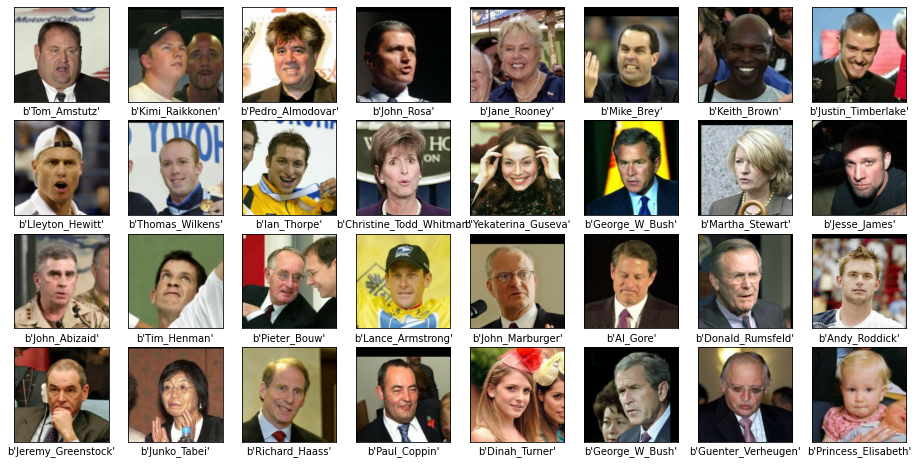

In [ ]:
ds = train_ds.take(32)

fig = plt.figure(figsize=(16, 8))
j = 0
for label, image in tfds.as_numpy(ds):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(image)
    plt.xticks([]), plt.yticks([])
    plt.xlabel(str(label))
    j += 1
plt.show()

Модель CNN

In [ ]:
# размерность
EMB_SIZE = 128

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

**Contrastive loss** для пары объектов, если объекты близки (похожи, из одного класса) - приближать их векторы, если это разные классы - удалять векторы.



In [ ]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    # батч эмбедингов и метки
    bs = embs.shape[0]
    # эмбеддинги по парам
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    # лейблы по парам
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

Подготовка и обучение модели

In [ ]:
INP_SIZE = 250
NUM_EPOCHS = 3
BATCH_SIZE = 32

def prepare(label, img):
    img = tf.cast(img, tf.float32)/255.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

train_ds = train_ds.shuffle(buffer_size=len(train_ds))
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=len(test_ds))
test_ds = test_ds.map(prepare)
test_ds = test_ds.repeat(NUM_EPOCHS)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [ ]:
%%time

# labels - номера классов
for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        # получаем эмбединги 
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))


[0] Loss: 85.08981323242188
[200] Loss: 0.3262811005115509
[400] Loss: 0.0
[600] Loss: 0.0
[800] Loss: 0.0
[1000] Loss: 0.4803262948989868
CPU times: user 4min 28s, sys: 8.63 s, total: 4min 37s
Wall time: 5min 23s


In [ ]:
for iteration, (images, labels) in enumerate(train_ds):
    if iteration != 0:
      break
    print(labels)

tf.Tensor(
[b'Sam_Gerald' b'Mark_Philippoussis' b'George_W_Bush' b'Gabriel_Valdes'
 b'Ahmed_Ghazi' b'Bertie_Ahern' b'Michael_Doleac' b'Fidel_Castro'
 b'Charles_Moose' b'Gerhard_Schroeder' b'John_Ashcroft' b'Hipolito_Mejia'
 b'John_Mayer' b'Yusaku_Miyazato' b'Michael_Jackson' b'Silvan_Shalom'
 b'Mark_Hurlbert' b'Richard_Regenhard' b'John_Howard' b'Colin_Powell'
 b'Donald_Rumsfeld' b'Enrique_Iglesias' b'Gunter_Pleuger' b'Tracy_McGrady'
 b'Timothy_Coughlin' b'Sophia_Loren' b'Caio_Blat' b'Jan_Bjoerklund'
 b'Michael_Bloomberg' b'Jeff_Bridges' b'Iban_Mayo' b'Kim_Ryong-sung'], shape=(32,), dtype=string)


In [ ]:
person_emb_train = model.predict(train_ds)

Получение эмбеддингов для тестовой выборки

In [ ]:
name1 = b'Aaron_Peirsol'
name2 = b'Charles_Taylor'

images_names = []

for images_batch, names_batch in iter(test_ds):
    mask = (names_batch == name1) | (names_batch == name2)
    
    images = images_batch[mask]
    names = names_batch[mask]
    
    images_names += list(zip(images, names))

In [ ]:
from itertools import combinations

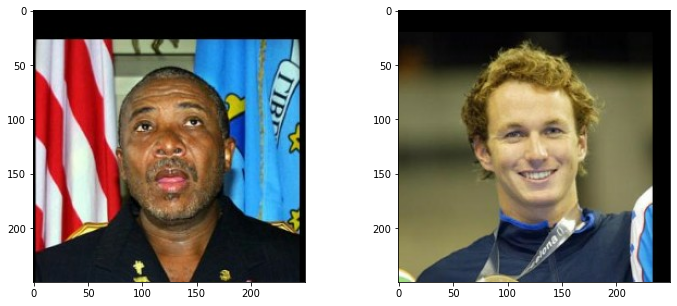

Charles_Taylor <-> Aaron_Peirsol: 17.4061


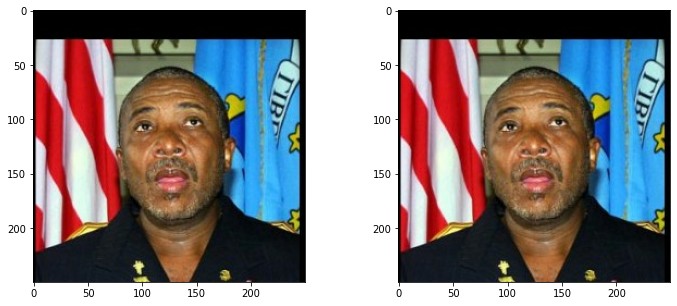

Charles_Taylor <-> Charles_Taylor: 0.0


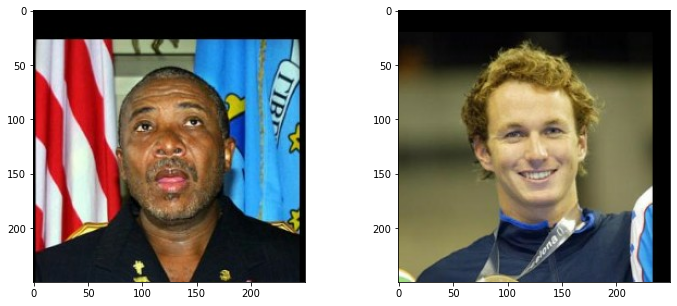

Charles_Taylor <-> Aaron_Peirsol: 17.4061


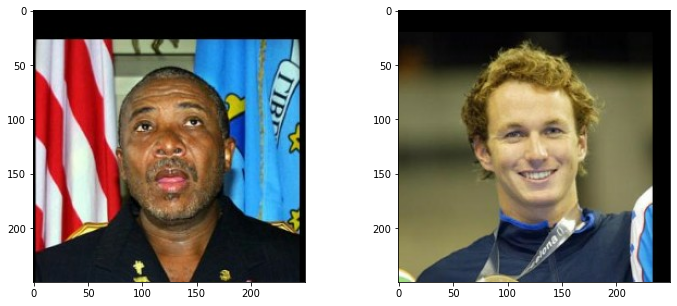

Charles_Taylor <-> Aaron_Peirsol: 17.4061


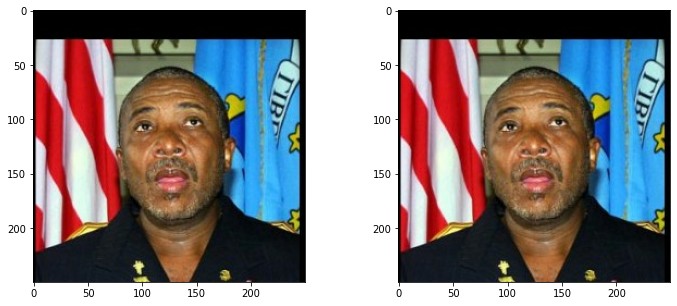

Charles_Taylor <-> Charles_Taylor: 0.0


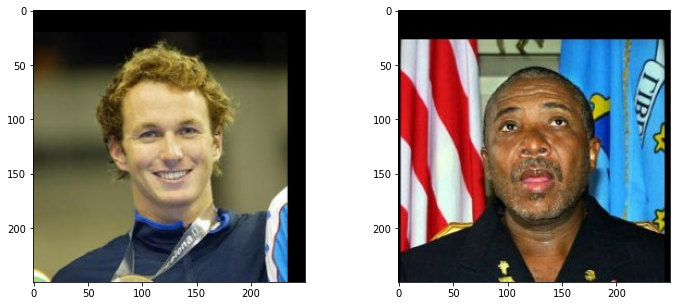

Aaron_Peirsol <-> Charles_Taylor: 17.4061


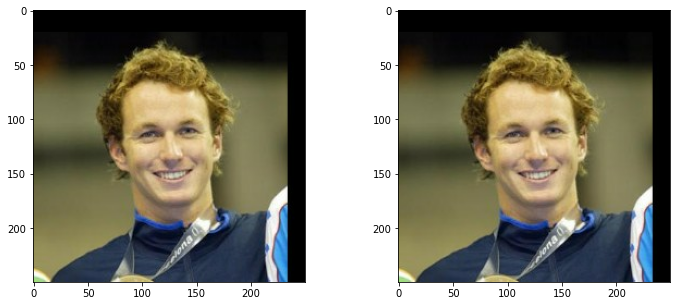

Aaron_Peirsol <-> Aaron_Peirsol: 0.0


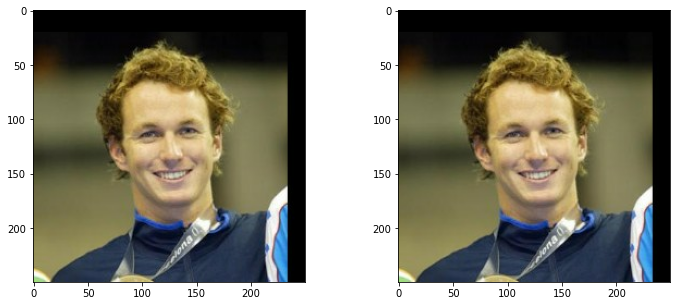

Aaron_Peirsol <-> Aaron_Peirsol: 0.0


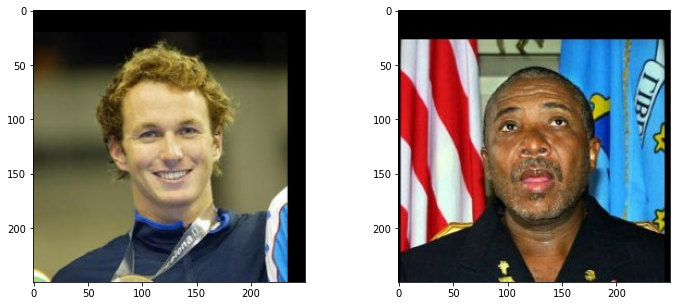

Aaron_Peirsol <-> Charles_Taylor: 17.4061


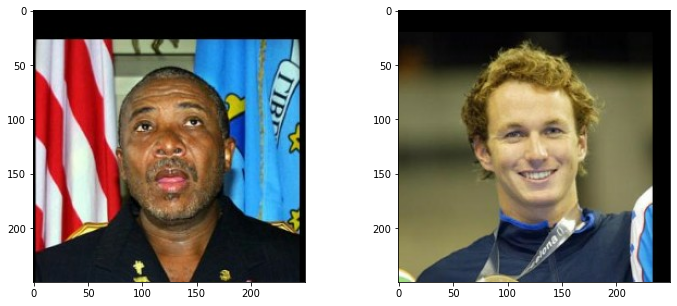

Charles_Taylor <-> Aaron_Peirsol: 17.4061


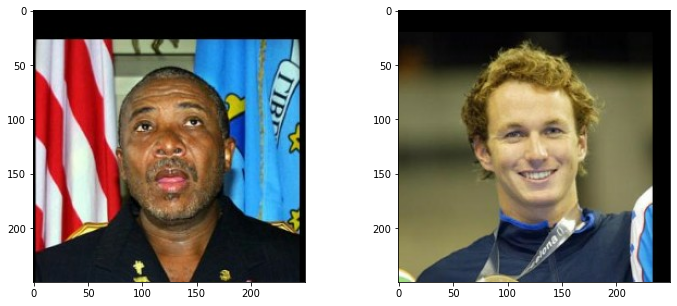

Charles_Taylor <-> Aaron_Peirsol: 17.4061


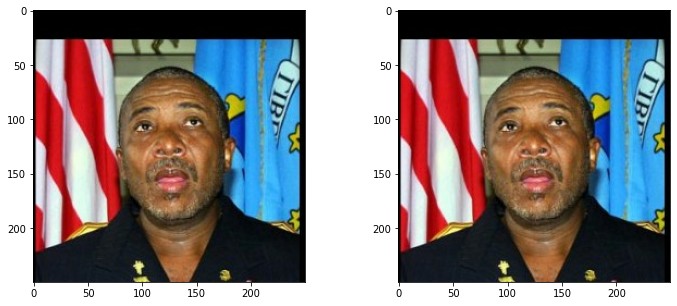

Charles_Taylor <-> Charles_Taylor: 0.0


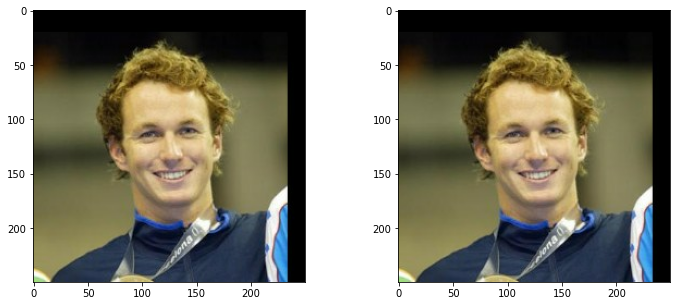

Aaron_Peirsol <-> Aaron_Peirsol: 0.0


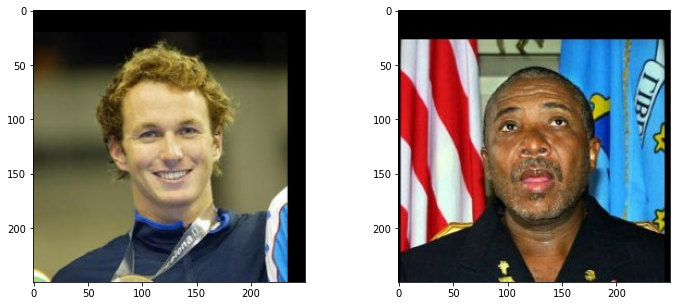

Aaron_Peirsol <-> Charles_Taylor: 17.4061


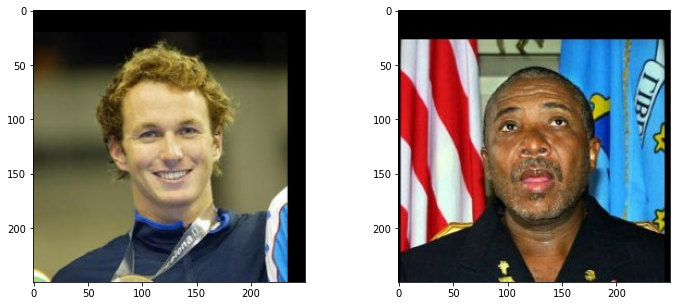

Aaron_Peirsol <-> Charles_Taylor: 17.4061


In [ ]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5


for (img1, name1), (img2, name2) in combinations(images_names, 2):

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].imshow(img1)
    ax[1].imshow(img2)
    plt.show()
    
    emb1 = model(img1[None])
    emb2 = model(img2[None])
    print(f'{name1.numpy().decode()} <-> {name2.numpy().decode()}:', round(diff(emb1, emb2), 4))